# Visualization

2021-04-15

In [19]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from statannot import add_stat_annotation
from anndata import AnnData

# Customized packages
from starmap.utilities import *
from starmap.sequencing import *
from starmap.obj import STARMapDataset, load_data
import starmap.analyze as anz
import starmap.viz as viz
import starmap.sc_util as su

# test()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get functions 

import colorsys
from random import shuffle

def intervals(parts, start_point, end_point):
    duration = end_point - start_point
    part_duration = duration / parts
    return [((i * part_duration + (i + 1) * part_duration)/2) + start_point for i in range(parts)]

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

## Input

In [3]:
# Load adata
adata = sc.read_h5ad('./output/2021-04-22-starmap-mAD-64-genes-scaled.h5ad')
adata

AnnData object with n_obs × n_vars = 36625 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score', 'leiden', 'top_level'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'top_hex_dict_64', 'top_level_order_64', 'top_rgb_dict_64'
    layers: 'corrected', 'norm', 'scaled'

In [25]:
# Load data and store the information to uns (use scaled version to save computational time)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    # Load segmentation
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Load plaque image
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    # uniform manual threshold 
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Load tau image
    current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)

    # Load Gfap image
    current_gfap_path = os.path.join(sample, 'scaled/Gfap_mask.tif')
    current_gfap = tifffile.imread(current_gfap_path)

    
    # Store the images to adata object
    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau
    adata.uns[current_key]['Gfap'] = current_gfap

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [5]:
# Restore convex hull and top-level info
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(adata.uns[current_key]['label_img'])
    
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'top_level'].cat.codes.values
    
    # add tau positive info
    # tau_threshold = 30
    # adata.uns[current_key]['tau_index'] = (adata.obs['tau'] > tau_threshold) & (current_index)
    

AD_mouse9721
Geting ConvexHull...
Used 9391 / 9391
AD_mouse9781
Geting ConvexHull...
Used 11328 / 11328
AD_mouse9919
Geting ConvexHull...
Used 10404 / 10404
AD_mouse9930
Geting ConvexHull...
Used 9829 / 9829


In [6]:
# Figure parameter
plt.rcParams['savefig.dpi'] = 100

## Top-level

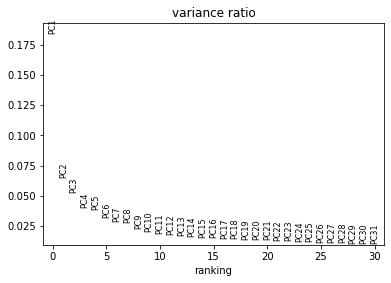

CPU times: user 1min 40s, sys: 3.01 s, total: 1min 43s
Wall time: 53.3 s


In [10]:
%%time
# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(adata, log=False)

# Computing the neighborhood graph
n_neighbors = 50
n_pcs = 30
cluster_resolution = 1

sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata)

### UMAP

In [ ]:
# Plot single meta UMAP
sc.pl.umap(adata, color='sample', save='_sample')
sc.pl.umap(adata, color='batch', save='_batch')
sc.pl.umap(adata, color='group', save='_group')
sc.pl.umap(adata, color='time', save='_time')

# Plot sample-wise UMAP
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    sc.pl.umap(adata, color='sample', groups=sample, save=f'_sample_{sample}')

# Plot group-wise UMAP
for group in sorted(adata.obs['group'].unique()):
    print(group)
    sc.pl.umap(adata, color='group', groups=group, save=f'_group_{group}')

# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}""")

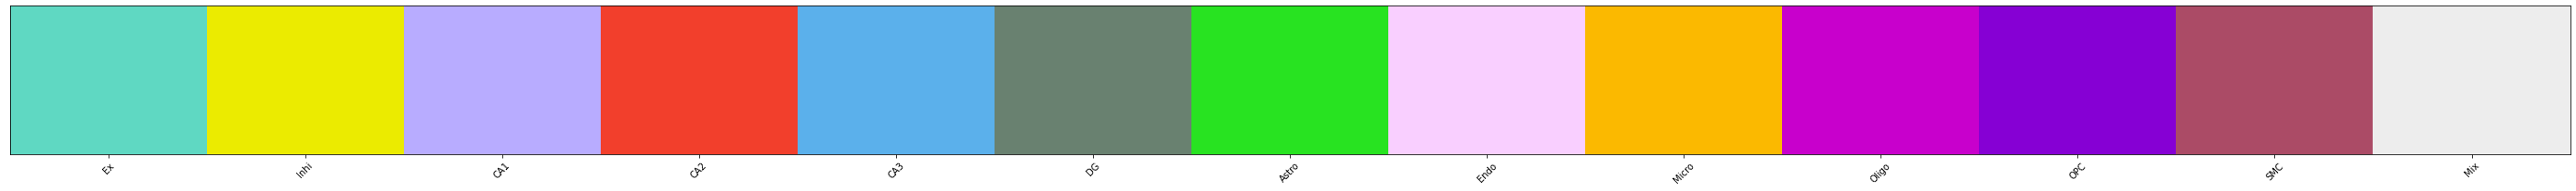

In [7]:
# Check color legend
top_cpl = []
for i in adata.uns['top_level_order_64']:
    top_cpl.append(adata.uns['top_rgb_dict_64'][i])

top_cpl = sns.color_palette(top_cpl)
top_cmap = ListedColormap(top_cpl.as_hex())
sns.palplot(top_cpl, size=3)
plt.xticks(range(len(adata.uns['top_level_order_64'])), adata.uns['top_level_order_64'], size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_top.png')
plt.show()

Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`


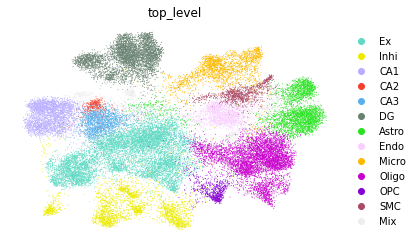

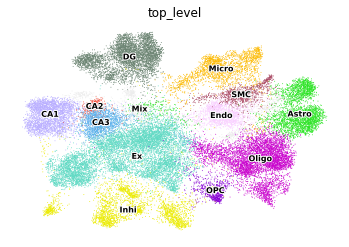

Trying to set attribute `.uns` of view, copying.


AD_mouse9721


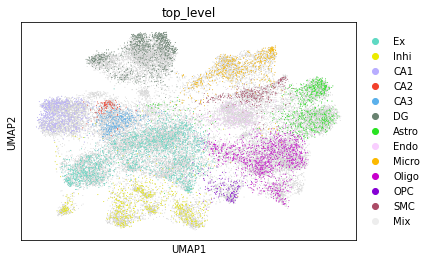

Trying to set attribute `.uns` of view, copying.


AD_mouse9781


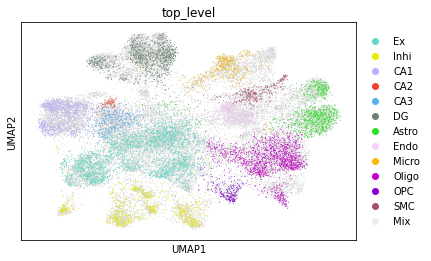

Trying to set attribute `.uns` of view, copying.


AD_mouse9919


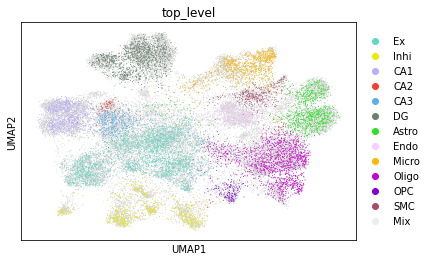

Trying to set attribute `.uns` of view, copying.


AD_mouse9930


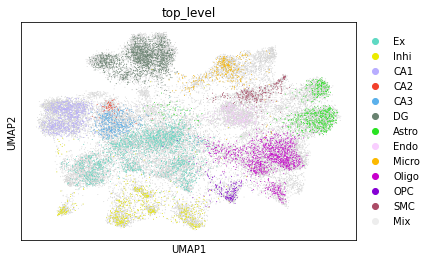

control


Trying to set attribute `.uns` of view, copying.


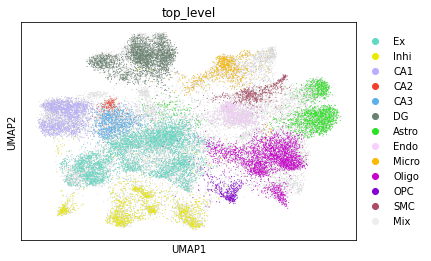

Trying to set attribute `.uns` of view, copying.


disease


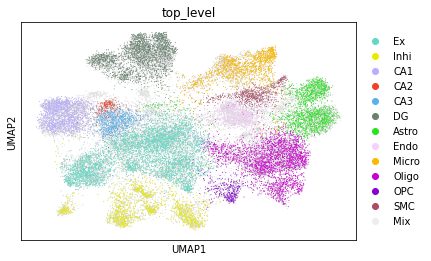

In [11]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', frameon=False, 
           palette=top_cpl, save='_legend_side')

# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=8, legend_fontoutline=2, frameon=False, 
           palette=top_cpl, save=True)

# Plot sample wise UMAP with top-level labels 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(adata, show=False, size=(120000 / adata.n_obs))
    sc.pl.umap(adata[adata.obs["sample"] == sample], color='top_level', frameon=True, ax=ax, size=(120000 / adata.n_obs),
               palette=top_cpl, save=f'_{sample}')

# Plot group wise UMAP with top-level labels 
for group in sorted(adata.obs['group'].unique()):
    print(group)
    ax = sc.pl.umap(adata, show=False, size=(120000 / adata.n_obs))
    sc.pl.umap(adata[adata.obs["group"] == group], color='top_level', frameon=True, ax=ax, size=(120000 / adata.n_obs),
               palette=top_cpl, save=f'_{group}')

### Marker related 

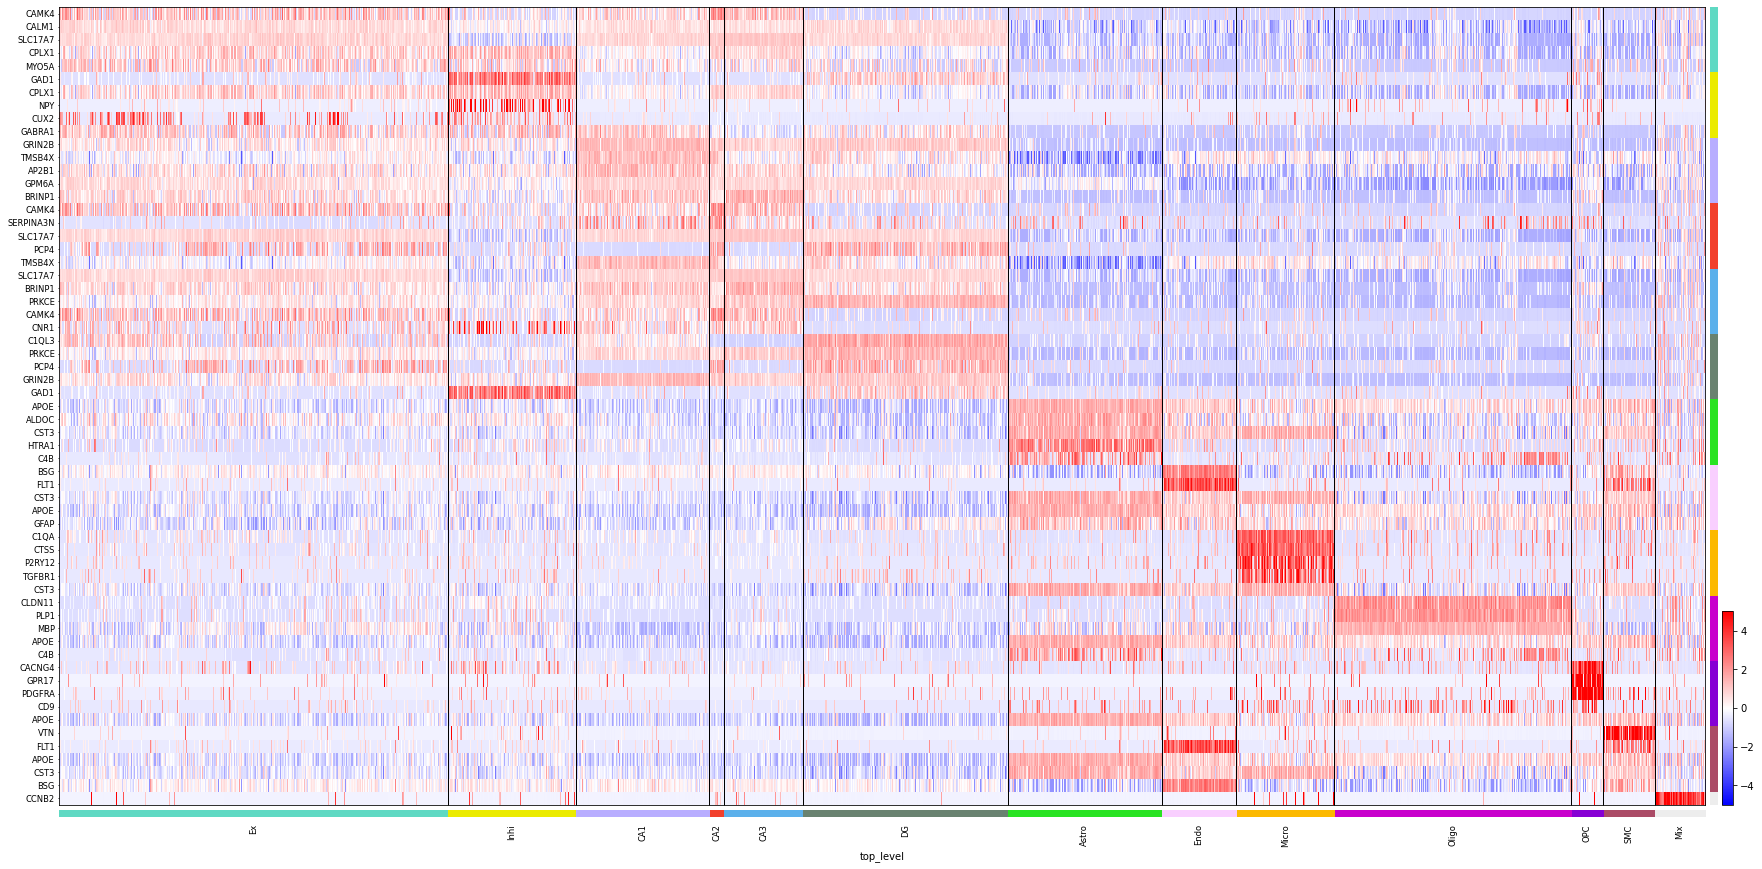

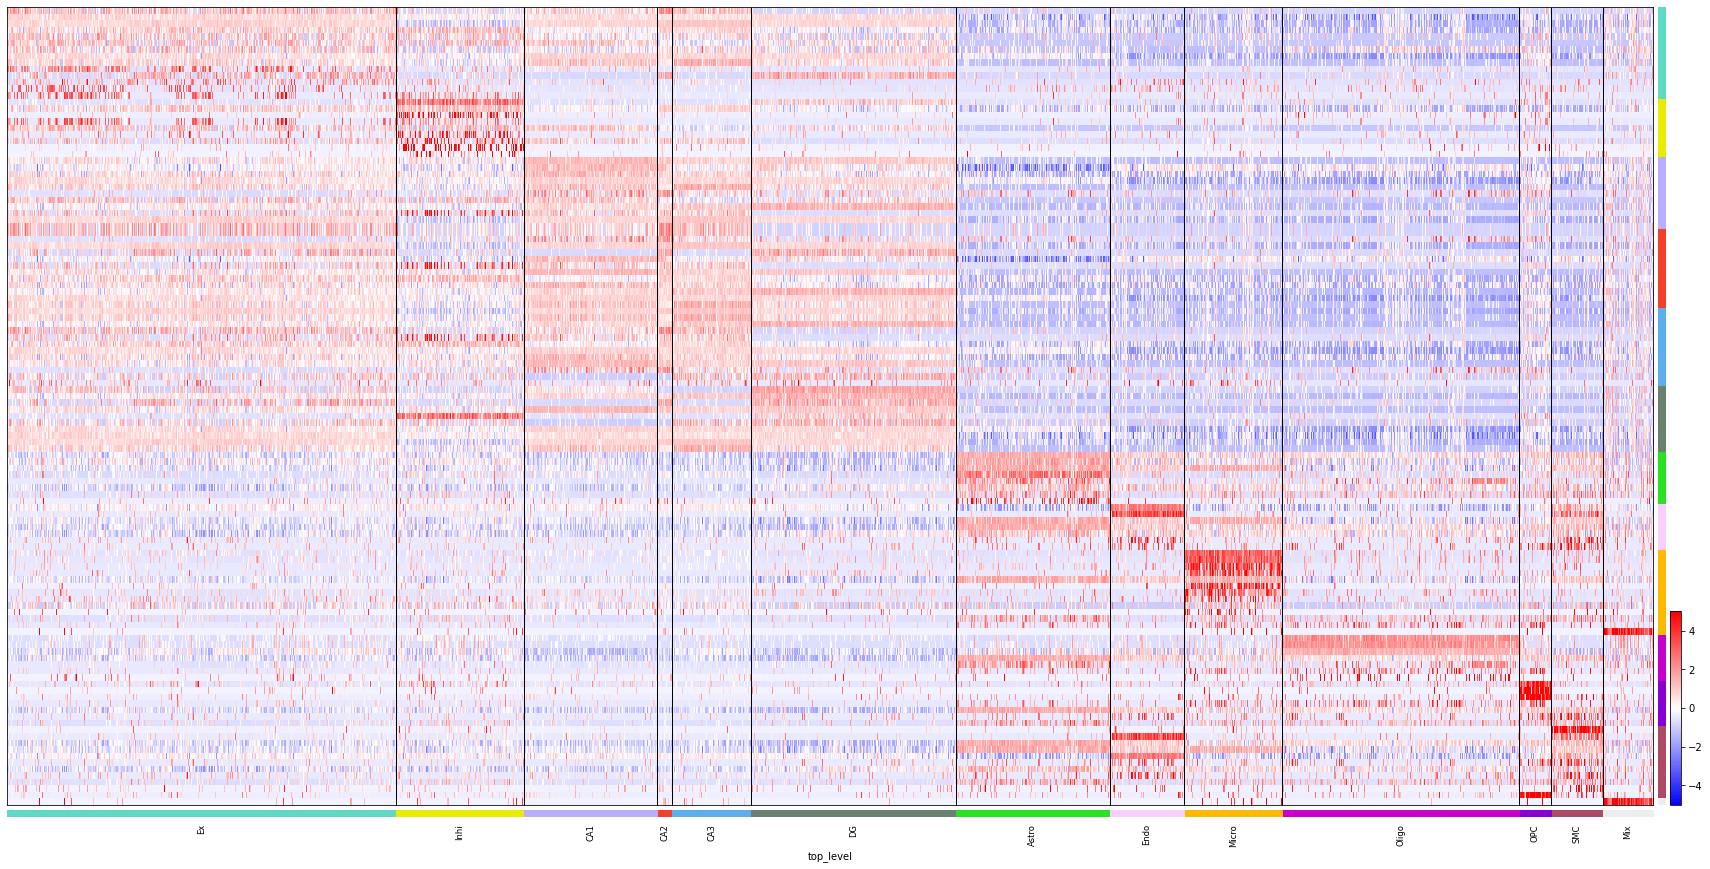

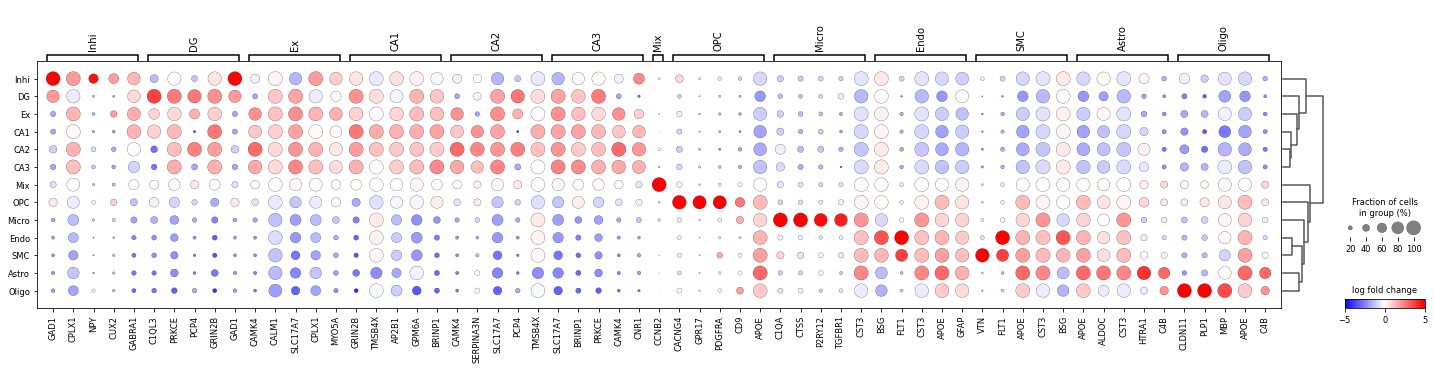

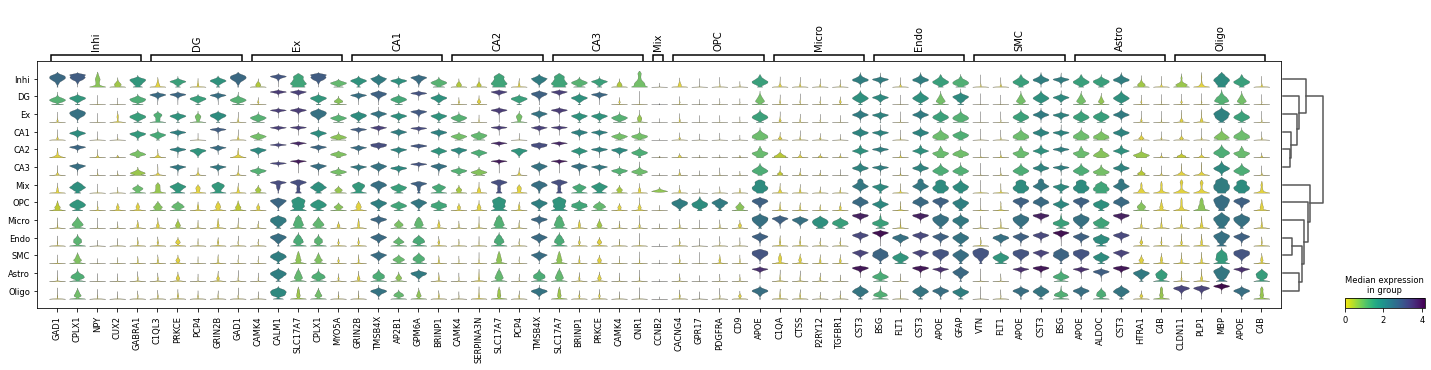

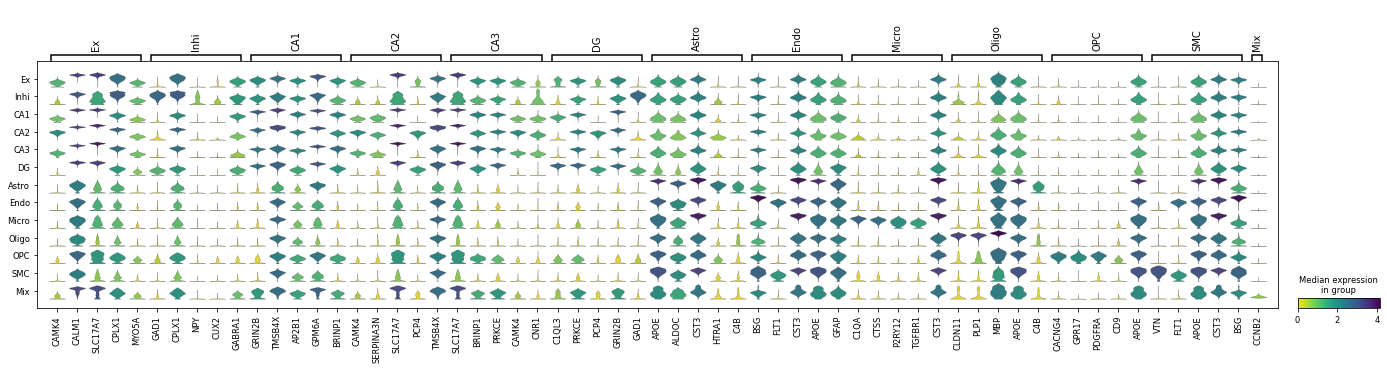

In [12]:
# Find gene markers for each cluster
sc.tl.rank_genes_groups(adata, 'top_level', method='wilcoxon')

# # Plot logFC heatmap
# sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
#                                 vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
#                                 dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot z-score heatmap big
sc.pl.rank_genes_groups_heatmap(adata, n_genes=15, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=False,
                                dendrogram=False, figsize=(30, 15), save='_zscore_big')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby='top_level', values_to_plot='logfoldchanges', min_logfoldchange=1, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, 
                                       cmap='viridis_r', save='top')

# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, 
                                       cmap='viridis_r', dendrogram=False, save='top_noden')


# # Print markers 
# markers = []
# temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
# for i in range(temp.shape[1]):
#     curr_col = temp.iloc[:, i].to_list()
#     markers = markers + curr_col
#     print(curr_col)
    
# print(markers)
# plt.figure(figsize=(20,10))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', use_labels=top_level_order,
#                             cmap=cluster_cmap, show_axis=True, font_size=10)
# plt.savefig('./figures/heatmap_top_v2.pdf')

### Composition bar plot

In [ ]:
# Composition Barplot 
n_cat = adata.obs['sample'].cat.categories.shape[0]
fig, ax = plt.subplots(n_cat, 1, figsize=(10,10))
fig.tight_layout()

for i, sample in enumerate(adata.obs['sample'].cat.categories):
    
    curr_cells = (adata.obs['sample'] == sample)
    temp = adata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['top_level'].value_counts())
    cell_dist['counts'] = cell_dist['top_level']
    cell_dist['top_level'] = cell_dist.index
    cell_dist['top_level'] = cell_dist['top_level'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    cell_dist['top_level'] = cell_dist['top_level'].astype('category')
    cell_dist['top_level'] = cell_dist['top_level'].cat.reorder_categories(adata.uns['top_level_order'])


    g = sns.barplot(x='top_level', y='counts', data=cell_dist, palette=top_cpl, ax=ax[i]) 
    for index, sub in enumerate(cell_dist['top_level'].cat.categories):
        curr_position = round(cell_dist.loc[cell_dist['top_level'] == sub, 'counts'].values[0], 1)
        g.text(index, curr_position, curr_position, color='black', ha="center")

    for spine in ax[i].spines.values():
        spine.set_visible(False)
        
    ax[i].set_ylabel(sample, rotation=0, labelpad=50)
    # ax[i].set(ylim=(0, 1000))
    if i == n_cat-1:
        ax[i].get_xaxis().set_visible(True)
        ax[i].tick_params(top=False, bottom=True, left=False, right=False,
                          labeltop=False, labelleft=False, labelright=False, labelbottom=True)
    else:
        ax[i].get_xaxis().set_visible(False)
        ax[i].tick_params(top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelleft=False, labelright=False, labelbottom=False)
            
fig.suptitle(f'Top-level cell type count', y=1.03)  
plt.savefig('./figures/top_level_count_barplot.pdf', bbox_inches='tight')
plt.show()

### Spatial cell type map

In [9]:
# Spatial cell type map
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(adata, sample, top_cmap, show_plaque=True, show_tau=True, linewidth=0.5,
                                        figscale=3, width=10, height=10, save=True, show=False)

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [8]:
# Spatial cell type map
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(adata, sample, top_cmap, show_plaque=True, show_tau=True, 
                                         save_as_real_size=True, linewidth=0.5,
                                        figscale=3, width=10, height=10, save=True, show=False)

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


## Sub-level

In [7]:
# Subset
sub_id = 'Astro'
curr_cells = adata.obs['top_level'] == sub_id
sdata = adata[curr_cells, :]
sdata

View of AnnData object with n_obs × n_vars = 3423 × 64
    obs: 'orig_index', 'sample', 'area', 'tau', 'gfap', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'predicted_top_level', 'predicted_top_level_score', 'predicted_cell_type', 'predicted_cell_type_score', 'predicted_cell_type_label', 'predicted_cell_type_label_score', 'leiden', 'top_level'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'mean', 'std'
    uns: 'AD_mouse9721_morph', 'AD_mouse9781_morph', 'AD_mouse9919_morph', 'AD_mouse9930_morph', 'top_hex_dict_64', 'top_level_order_64', 'top_rgb_dict_64'
    layers: 'corrected', 'norm', 'scaled'

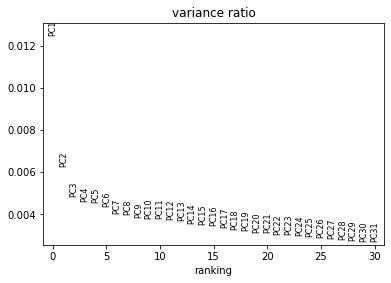

CPU times: user 20.2 s, sys: 945 ms, total: 21.2 s
Wall time: 7.14 s


In [7]:
%%time
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 5
cluster_resolution = .3


sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)

### UMAP

In [ ]:
# Plot UMAP
sc.pl.umap(sdata, color='sample', save='_sample')
sc.pl.umap(sdata, color='batch', save='_batch')
sc.pl.umap(sdata, color='group', save='_group')
sc.pl.umap(sdata, color='time', save='_time')

# Plot sample-wise UMAP
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    sc.pl.umap(sdata, color='sample', groups=sample, save=f'_sample_{sample}')

# Plot group-wise UMAP
for group in sorted(sdata.obs['group'].unique()):
    print(group)
    sc.pl.umap(sdata, color='group', groups=group, save=f'_group_{group}')


# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}""")

In [ ]:
# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if '/' in i:
        curr_key = i.split('/')
        sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
    else:       
        sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

In [ ]:
# UMAP cell type label
sc.pl.umap(sdata, color='cell_type_label', frameon=False, 
           palette=sub_cpl, save=f'_label_legend_side')

# Save plots (cell_type_label)
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='cell_type_label', legend_loc='on data',
           legend_fontsize=10, legend_fontoutline=2, frameon=False, 
           palette=sub_cpl, save=f'_label')

# Plot sample wise UMAP with sub-level labels 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["sample"] == sample], color='cell_type_label', frameon=True, ax=ax, size=(120000 / sdata.n_obs),
               palette=sub_cpl, save=f'_label_{sample}')

# Plot group wise UMAP with sub-level labels 
for group in sorted(sdata.obs['group'].unique()):
    print(group)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["group"] == group], color='cell_type_label', frameon=False, ax=ax, size=(120000 / sdata.n_obs),
               palette=sub_cpl, save=f'_label_{group}')


In [8]:
# Pseudotime 

# load pseudotime file 
time_df = pd.read_csv('./pseudotime/AD_Micro_pseudotime.csv')
time_df 

,orig_index,sample,area,tau,x,y,batch,time,group,n_genes_by_counts,...,X__is_in_cluster__,top_level,cell_type,region,cell_type_label,nCount_RNA,nFeature_RNA,pseudotime,UMAP1,UMAP2
0,13,AD_mouse9494,5765,0.0,3826,8,batch_2,13_months,disease,90,...,False,Micro,Micro_Cst7/Ctsb,Hippocampus,M3,109,87,11.938498,-1.016800,0.815882
1,42,AD_mouse9494,9402,0.0,2317,31,batch_2,13_months,disease,135,...,False,Micro,Micro_Gpr34,Hippocampus,M2,169,128,16.923545,-4.412405,-1.738135
2,45,AD_mouse9494,7073,0.0,1292,34,batch_2,13_months,disease,102,...,False,Micro,Micro_Gpr34,Hippocampus,M2,106,95,18.651894,-2.404822,-2.965408
3,51,AD_mouse9494,7603,0.0,2178,37,batch_2,13_months,disease,89,...,False,Micro,Micro_Cst7/Ctsb,Hippocampus,M3,111,83,16.975059,-3.537116,-2.384354
4,53,AD_mouse9494,9387,0.0,885,35,batch_2,13_months,disease,172,...,False,Micro,Micro_Gpr34,Hippocampus,M2,188,159,0.501767,4.437535,0.198064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,7991,AD_mouse9498,8271,0.0,5627,6530,batch_2,13_months,control,120,...,False,Micro,Micro,Hippocampus,M1,132,113,13.079931,-2.110824,1.271107
1719,8020,AD_mouse9498,6752,0.0,1209,6549,batch_2,13_months,control,95,...,False,Micro,Micro_Gpr34,Hippocampus,M2,104,93,11.380684,-1.551972,2.806060
1720,8117,AD_mouse9498,6811,0.0,4117,6625,batch_2,13_months,control,101,...,False,Micro,Micro,Hippocampus,M1,111,93,11.887461,-0.855873,0.926867
1721,8136,AD_mouse9498,9350,0.0,3953,6639,batch_2,13_months,control,100,...,False,Micro,Micro,Hippocampus,M1,111,91,4.192917,0.755105,-2.210421


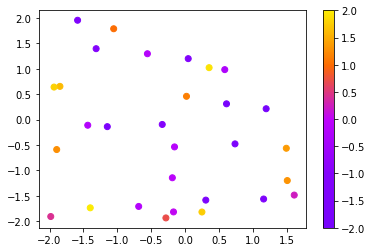

In [9]:
# Test customized linear colormap
# test = ["#33db27", "#f0f029", '#ed5d28']
# test = ["#2997ff", "#33db27", "#f0f029", '#ed5d28']
# test = ["#7703fc", "#8403fc", "#be03fc", "#fc6b03", '#fceb03']
test = ["#7703fc", "#8403fc", "#be03fc", "#fc6b03", '#fceb03'] # try blue to red 
x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-2,2)
cmap = LinearSegmentedColormap.from_list("", test)

plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [14]:
# OR use preset colormap
cmap = sns.color_palette('plasma', as_cmap=True)

AD_mouse9494


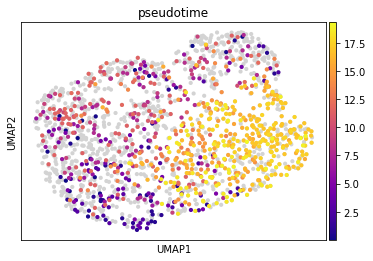

AD_mouse9498


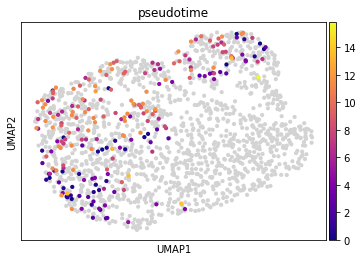

AD_mouse9723


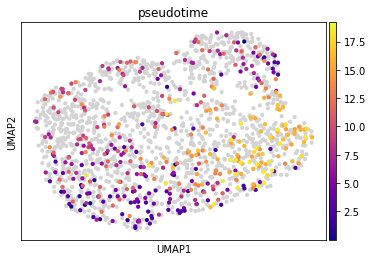

AD_mouse9735


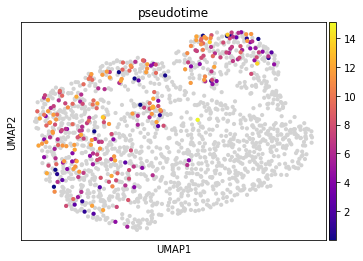

In [15]:
sdata.obs['pseudotime'] = time_df['pseudotime'].values

# Plot sample wise UMAP with sub-level labels 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["sample"] == sample], color='pseudotime', frameon=True, ax=ax, size=(120000 / sdata.n_obs),
               color_map=cmap)


In [ ]:
meta_df = time_df
current_meta = 'pseudotime'
# subset_type = ['Micro']

vmin = meta_df[current_meta].min()
vmax = meta_df[current_meta].max()

for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)

    current_meta_df = meta_df.loc[meta_df['sample'] == sample, :]

    current_orig_index = current_meta_df['orig_index'].astype(str)
    
    sdata = adata[adata.obs['sample'] == sample, :]
    current_index = sdata.obs['orig_index'].astype(str).isin(current_orig_index)
    sdata = sdata[current_index, :]
    sdata.obs[current_meta] = current_meta_df[current_meta].values

    

### Marker related

In [ ]:
# Find gene markers for each cluster
sc.tl.rank_genes_groups(sdata, 'cell_type', method='wilcoxon')

min_logfoldchange = .5
# Plot logFC heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
                                dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(sdata, n_genes=5, groupby='cell_type', values_to_plot='logfoldchanges', min_logfoldchange=min_logfoldchange, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, 
                                       cmap='viridis_r', save=sub_id)

# Plot expression violin plot
sc.pl.rank_genes_groups_stacked_violin(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=min_logfoldchange, 
                                       cmap='viridis_r', dendrogram=False, save=f'{sub_id}_noden')

# Plot expression matrix plot
sc.pl.rank_genes_groups_matrixplot(sdata, n_genes=5, use_raw=False, vmin=-5, vmax=5, cmap='bwr', layer='scaled',
                                  dendrogram=False, min_logfoldchange=min_logfoldchange, save=sub_id)

# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(2)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)
    
# print(markers)
# plt.figure(figsize=(20,10))
# su.plot_heatmap_with_labels(adata, markers, 'leiden', use_labels=top_level_order,
#                             cmap=cluster_cmap, show_axis=True, font_size=10)
# plt.savefig('./figures/heatmap_top_v2.pdf')

In [ ]:
# Marker Barplot 
# markers = markers[0:4]
n_markers = len(markers)
fig, ax = plt.subplots(n_markers, 1, figsize=(5,10))
fig.tight_layout()

for i, gene in enumerate(markers):
    expr = sdata.raw[:, gene].X.flatten()
    cluster = sdata.obs['cell_type']
    curr_df = pd.DataFrame({'cluster': cluster, 'expr': expr})
    # print(curr_df)
    sns.barplot(x="cluster", y="expr", data=curr_df, ax=ax[i], capsize=.2, errwidth=1, palette=sub_cpl)
    for spine in ax[i].spines.values():
        spine.set_visible(False)
        
    change_width(ax[i], .35)
    ax[i].set_ylabel(markers[i], rotation=0, labelpad=20)
    ax[i].set(ylim=(0, 1.5))
    ax[i].tick_params(axis='x', rotation=45)
    if i == n_markers-1:
        ax[i].get_xaxis().set_visible(True)
        ax[i].tick_params(top=False, bottom=True, left=False, right=True,
                          labeltop=False, labelleft=False, labelright=True, labelbottom=True)
    else:
        ax[i].get_xaxis().set_visible(False)
        ax[i].tick_params(top=False, bottom=False, left=False, right=True,
                          labeltop=False, labelleft=False, labelright=True, labelbottom=False)
 
fig.suptitle(f'{sub_id} marker gene expression', y=1.03) 
plt.savefig('./figures/marker_barplot.pdf', bbox_inches='tight')
plt.show()

### Composition bar plot 

In [ ]:
# Composition Barplot 
sample_tags = ['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)']

cell_dist_list = []
for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    
    curr_cells = (sdata.obs['sample'] == sample)
    temp = sdata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['cell_type_label'].value_counts())
    cell_dist['counts'] = cell_dist['cell_type_label']
    cell_dist['cell_type_label'] = cell_dist.index
    cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    # cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')
    
#     for j in curr_cell_type:
#         if j not in cell_dist['cell_type_label'].unique():
#             cell_dist = cell_dist.append({'cell_type_label': j, 'counts': 0}, ignore_index=True)
    
    cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype('category')
    # cell_dist['cell_type_label'] = cell_dist['cell_type_label'].cat.reorder_categories(curr_cell_type)
    cell_dist['sample'] = sample_tags[i]
    cell_dist_list.append(cell_dist)


In [ ]:
cell_dist_total = pd.concat(cell_dist_list)

fig, ax = plt.subplots(figsize=(7,7))
ax = sns.barplot(x="cell_type_label", y="counts", hue="sample", data=cell_dist_total, ax=ax)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.setp(ax.patches, linewidth=1, edgecolor='black')
plt.savefig(f'./figures/{sub_id}_composition.pdf')

In [ ]:
# Composition Barplot 
n_cat = sdata.obs['sample'].cat.categories.shape[0]
fig, ax = plt.subplots(n_cat, 1, figsize=(5,10))
fig.tight_layout()

for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    
    curr_cells = (sdata.obs['sample'] == sample)
    temp = sdata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['cell_type'].value_counts())
    cell_dist['counts'] = cell_dist['cell_type']
    cell_dist['cell_type'] = cell_dist.index
    cell_dist['cell_type'] = cell_dist['cell_type'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')
    
    for j in curr_cell_type:
        if j not in cell_dist['cell_type'].unique():
            cell_dist = cell_dist.append({'cell_type': j, 'counts': 0}, ignore_index=True)
    
    cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')
    cell_dist['cell_type'] = cell_dist['cell_type'].cat.reorder_categories(curr_cell_type)


    g = sns.barplot(x='cell_type', y='counts', data=cell_dist, palette=sub_cpl, ax=ax[i]) 
    for index, sub in enumerate(cell_dist['cell_type'].cat.categories):
        curr_position = round(cell_dist.loc[cell_dist['cell_type'] == sub, 'counts'].values[0], 1)
        g.text(index, curr_position, curr_position, color='black', ha="center")

    for spine in ax[i].spines.values():
        spine.set_visible(False)
    
    change_width(ax[i], .35)
    ax[i].set_ylabel(sample, rotation=0, labelpad=50)
    ax[i].set(ylim=(0, 1000))
    ax[i].tick_params(axis='x', rotation=45)
    if i == n_cat-1:
        ax[i].get_xaxis().set_visible(True)
        ax[i].tick_params(top=False, bottom=True, left=False, right=False,
                          labeltop=False, labelleft=False, labelright=False, labelbottom=True)
    else:
        ax[i].get_xaxis().set_visible(False)
        ax[i].tick_params(top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelleft=False, labelright=False, labelbottom=False)
            
            
fig.suptitle(f'{sub_id} cell type count', y=1.03) 
fig.savefig('./figures/cell_type_count_barplot.pdf', bbox_inches='tight')
plt.show()

### Composition Pie chart

In [ ]:
# pie chart

for i, sample in enumerate(sdata.obs['sample'].cat.categories):
    
    curr_cells = (sdata.obs['sample'] == sample)
    temp = sdata[curr_cells, :]

    cell_dist = pd.DataFrame(temp.obs['leiden'].value_counts())
    cell_dist['counts'] = cell_dist['leiden']
    cell_dist['leiden'] = cell_dist.index
    cell_dist['leiden'] = cell_dist['leiden'].astype(object)
    cell_dist = cell_dist.reset_index(drop=True)
    cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')
    
    for j in curr_cell_type:
        if j not in cell_dist['leiden'].unique():
            cell_dist = cell_dist.append({'leiden': j, 'counts': 0}, ignore_index=True)
    
    cell_dist['leiden'] = cell_dist['leiden'].astype('category')
    #cell_dist['leiden'] = cell_dist['leiden'].cat.reorder_categories(curr_cell_type)
    
    n_cells = cell_dist['counts'].sum()
    cell_dist['counts'] = cell_dist['counts'].div(cell_dist['counts'].sum(axis=0), axis=0).multiply(100)
    cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
    
#     sub_cpl = []
#     for i in cell_dist['cell_type']:
#         if '/' in i:
#             curr_key = i.split('/')
#             sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
#         else:       
#             sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

#     sub_cpl = sns.color_palette(sub_cpl)

    fig, ax = plt.subplots(figsize=(10,10))
    _, _, autopcts = ax.pie(cell_dist['counts'], labels=cell_dist['leiden'], autopct='%1.1f%%', colors=sub_cpl,
          textprops={'size': 15, 'weight':'bold'})
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f"{sample} - Number of cells: {n_cells}", fontsize=15, weight='bold', y=1.05)
    plt.setp(autopcts, **{'color':'black', 'weight':'bold', 'fontsize':12.5})
    plt.tight_layout()
    #plt.savefig(f'./figures/{sample}_{sub_id}_pie_{region_type}.pdf', bbox_inches='tight')
    plt.show()

### Spatial cell type map

In [ ]:
# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'cell_type'].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    su.plot_poly_cells_cluster_by_sample(sdata, sample, sub_cmap, show_plaque=True, show_tau=True,
                                        figscale=3, width=10, height=10, save=True, show=False)

## Others

### Spatial map with Gfap 

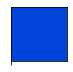

In [63]:
cpl = sns.color_palette(['#0045db'], as_cmap=True)
cmap = ListedColormap(cpl)
sns.palplot(cpl)

In [68]:
# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'top_level'].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    su.plot_poly_cells_cluster_by_sample(sdata, sample, cmap, show_plaque=True, show_tau=True,
                                         save_as_real_size=True, linewidth=0.5, show_gfap=True,
                                        figscale=3, width=10, height=10, save='Gfap', show=False)

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


### Spatial map of gene expression

In [ ]:
curr_gene = 'CPLX1'
# subset_type = 'Oligo'
subset_type = None

cmap = sns.color_palette('viridis', as_cmap=True)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    
    if subset_type is not None:
        current_index = adata.obs['top_level'] == subset_type
        sdata = adata[current_index, :]
    else:
        sdata = adata

    current_index = sdata.obs['sample'] == sample
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
        
    su.plot_poly_cells_expr_by_sample(sdata, sample, curr_gene, cmap, use_raw=False,
                                      figscale=30, width=10, height=10,
                                      show_plaque=True, show_tau=True, show_tau_cells=False,
                                      show=False, save=f'{curr_gene}_z')

### Spatial map of pseudotime

In [ ]:
# load pseudotime file 
time_df = pd.read_csv('./AD_OPC_Oligo_pseudotime.csv')
time_df 

In [ ]:
# Test customized linear colormap
# test = ["#33db27", "#f0f029", '#ed5d28']
# test = ["#2997ff", "#33db27", "#f0f029", '#ed5d28']
test = ["#7703fc", "#8403fc", "#be03fc", "#fc6b03", '#fceb03']
x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-2,2)
cmap = LinearSegmentedColormap.from_list("", test)

plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [ ]:
# OR use preset colormap
cmap = sns.color_palette('plasma', as_cmap=True)

In [ ]:
meta_df = time_df
current_meta = 'pseudotime'
# subset_type = ['Micro']

vmin = meta_df[current_meta].min()
vmax = meta_df[current_meta].max()

for sample in sorted(adata.obs['sample'].unique()):
    print(sample)

    current_meta_df = meta_df.loc[meta_df['sample'] == sample, :]

    current_orig_index = current_meta_df['orig_index'].astype(str)
    
    sdata = adata[adata.obs['sample'] == sample, :]
    current_index = sdata.obs['orig_index'].astype(str).isin(current_orig_index)
    sdata = sdata[current_index, :]
    sdata.obs[current_meta] = current_meta_df[current_meta].values

    current_key = f"{sample}_morph"
    sdata.uns[current_key]['good_cells'] = sdata.obs['orig_index'].astype(int).values

    su.plot_poly_cells_meta_by_sample(sdata, sample, current_meta, cmap, use_raw=True,
                                      figscale=10, width=10, height=10, vmin=vmin, vmax=vmax,
                                      show_plaque=True, show_tau=True, show_colorbar=True,
                                      show=False, save=current_meta)

### Spatial cell type map of multiple groups

In [ ]:
# group spatial cell type map 

plot_type = 'top_level'
plot_list = ['Ex', 'Inhi']
# plot_list = ['Endo', 'SMC']
# plot_list = ['CA1', 'CA2', 'CA3', 'DG', 'LHb']
# plot_list = ['Oligo', 'OPC']
# plot_list = ['Micro_Cst7/Ctsb', 'Oligo_Neat1/Enpp2']
# plot_list = ['Micro_Cst7/Ctsb', 'Astro']
# plot_list = ['Astro_Gfap/Vim', 'Oligo_Klk6']

curr_cells = adata.obs[plot_type].isin(plot_list)
sdata = adata[curr_cells, :]
# sdata
sdata.obs[plot_type] = sdata.obs[plot_type].cat.reorder_categories(plot_list)

if plot_list[0] in ['Micro_Cst7/Ctsb', 'Astro_Gfap/Vim']:
    curr_cpl = ['#fc8d62', '#1ec700']
    curr_cpl = sns.color_palette(curr_cpl)
else:
    curr_cpl = sns.color_palette('Set1', len(plot_list)+1)
    curr_cpl.pop(0)
    
curr_cmap = ListedColormap(curr_cpl.as_hex())
sns.palplot(curr_cpl, size=3)
plt.xticks(range(len(plot_list)), plot_list, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend.png')
plt.show()

# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, plot_type].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    su.plot_poly_cells_cluster_by_sample(sdata, sample, curr_cmap, show_plaque=True, show_tau=True,
                                        figscale=30, width=10, height=10, save=True, show=False)

### Gene set score related

In [ ]:
# Astro related gene module 
pan_reactive_genes = ['LCN2', 'STEAP4', 'S1PR3', 'TIMP2', 'HSPB1',
                     'CXCL10', 'CD44', 'OSMR', 'CP', 'SERPINA3N',
                     'ASPG', 'VIM', 'GFAP']
a1_genes = ['H2-T23', 'SERPING1', 'H2-D1', 'GGTA1', 'LIGP1', 'GBP2',
           'FBIN5', 'UGT1A1', 'FKBP5', 'PSMB8', 'SRGN', 'AMIGO2']
a2_genes = ['CLCF1', 'TGM1', 'PTX3', 'S100A10', 'SPHK1', 'CD109', 'PTGS2',
           'EMP1', 'SLC10A6', 'TM4SF1', 'B3GNT5', 'CD14']

# module from file
module_name = 'Neurodegen'

gene_module = pd.read_excel('Friedman_modules_for_Julia.xlsx', sheet_name=module_name)
gene_module = gene_module.iloc[:, 0].astype(str).str.upper().to_list()

In [ ]:
# group color map
group_cpl = sns.color_palette('tab10', 2)
sns.palplot(group_cpl, size=3)

In [ ]:
# print module genes
gene_module = list(set(gene_module) & set(adata.var.index))
print(len(gene_module))
print(gene_module)

In [ ]:
module_name = 'Pan reactive'

region_type = 'Cortex'
current_index = (adata.obs['region'] == region_type) & (~adata.obs['top_level'].isin(['CA1', 'CA2', 'CA3', 'DG']))
rdata = adata[current_index, :]
sc.tl.score_genes(rdata, gene_module)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='top_level', y='score', hue='group', data=rdata.obs, ax=ax, palette=group_cpl)
add_stat_annotation(ax, data=rdata.obs, x='top_level', y='score', hue='group',
                    box_pairs=[(("Ex", "disease"), ("Ex", "control")),
                              (("Inhi", "disease"), ("Inhi", "control")),
                               (("Astro", "disease"), ("Astro", "control")),
                               (("Oligo", "disease"), ("Oligo", "control")),
                               (("OPC", "disease"), ("OPC", "control")),
                               (("Endo", "disease"), ("Endo", "control")),
                               (("SMC", "disease"), ("SMC", "control")),
                              (("Micro", "disease"), ("Micro", "control"))],
                    test='Mann-Whitney', text_format='star', verbose=2)

plt.title(f'A2 gene set score in {region_type}')
plt.show()

In [ ]:
subset_type = 'Astro'
current_index = rdata.obs['top_level'] == subset_type
sdata = rdata[current_index, :]
sc.tl.score_genes(sdata, gene_module)

# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if '/' in i:
        curr_key = i.split('/')
        sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
    else:       
        sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='cell_type', y='score', data=sdata.obs, ax=ax, palette=sub_cpl)
plt.title(f'A1 gene set score in Astrocytes')
add_stat_annotation(ax, data=sdata.obs, x='cell_type', y='score',
                    box_pairs=[("Astro", "Astro_Gfap/Vim")],
                    test='Mann-Whitney', text_format='star', verbose=2)
plt.show()

### Region-wise cell type density stacked bar plot

In [ ]:
all_list = []

# region Subset
region_list = ['Cortex', 'White Matter', 'Hippocampus', 'Subcortical']
# region_list = ['Subcortical']
# fig, ax = plt.subplots(len(region_list), 1, figsize=(10,15))

sub_id = 'Oligo'
for r, current_region in enumerate(region_list):
    
    if current_region == 'Cortex':
        current_index = (adata.obs['region'] == current_region) & (~adata.obs['top_level'].isin(['CA1', 'CA2', 'CA3', 'DG', 'LHb']))
    elif current_region == 'White Matter':
        current_index = (adata.obs['region'] == current_region) & (~adata.obs['top_level'].isin(['Ex', 'Inhi', 'CA1', 'CA2', 'CA3', 'DG', 'LHb']))
    elif current_region == 'Hippocampus':
        current_index = (adata.obs['region'] == current_region) 
    elif current_region == 'Subcortical':
        current_index = (adata.obs['region'].isin(['White Matter', 'Hippocampus'])) & (~adata.obs['top_level'].isin(['Ex']))
    
    # cell type Subset
    rdata = adata[current_index, :]
    curr_cells = rdata.obs['top_level'] == sub_id
    sdata = rdata[curr_cells, :]

    # Check color legend
    curr_cell_type = [] 
    for cell_type in sdata.uns['cell_type_label']:
        if cell_type in sdata.obs['cell_type_label'].unique():
            curr_cell_type.append(cell_type)

    sub_cpl = []
    for i in curr_cell_type:
        if '/' in i:
            curr_key = i.split('/')
            sub_cpl.append(sdata.uns['label_rgb_dict'][curr_key[0]][curr_key[1]])
        else:       
            sub_cpl.append(sdata.uns['label_rgb_dict'][i])

    sub_cpl = sns.color_palette(sub_cpl)
    sub_cmap = ListedColormap(sub_cpl.as_hex())
#     sns.palplot(sub_cpl, size=3)
#     plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
#     plt.tight_layout()
#     plt.savefig(f'./figures/color_legend_{sub_id}.png')
#     plt.show()

    # normalized barplot
    region_dict = {'Cortex':1, 'White Matter':2, 'Hippocampus':3}
    sample_tags = ['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)']

    cell_dist_list = []
    for i, sample in enumerate(sdata.obs['sample'].cat.categories):
        print(sample)
        curr_cells = (sdata.obs['sample'] == sample)
        temp = sdata[curr_cells, :]

        cell_dist = pd.DataFrame(temp.obs['cell_type_label'].value_counts())
        cell_dist['counts'] = cell_dist['cell_type_label']
        cell_dist['cell_type_label'] = cell_dist.index
        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype(object)
        cell_dist = cell_dist.reset_index(drop=True)
        # cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
        # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')

        for j in curr_cell_type:
            if j not in cell_dist['cell_type_label'].unique():
                cell_dist = cell_dist.append({'cell_type_label': j, 'counts': 0}, ignore_index=True)

        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].astype('category')
        cell_dist['cell_type_label'] = cell_dist['cell_type_label'].cat.reorder_categories(curr_cell_type)
        cell_dist['sample'] = sample_tags[i]
        # print(cell_dist.shape)
        cell_dist_list.append(cell_dist)

    cell_dist_total = pd.concat(cell_dist_list)
    cell_dist_total['cell_type_label'] = cell_dist_total['cell_type_label'].astype('category')
    cell_dist_total['sample'] = cell_dist_total['sample'].astype('category')
    cell_dist_total['sample'] = cell_dist_total['sample'].cat.reorder_categories(['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)'])
    
    current_area = 0
    for k, region in enumerate(regionprops(sdata.uns[f'{sample}_morph']['region'])):
        if current_region == 'Subcortical':
            if region.label != 1:
                current_area += region.area * 0.315 * 0.315
        else:
            if region.label == r+1:
                current_area = region.area * 0.315 * 0.315
                
    print(current_area)
    cell_dist_total['counts'] = cell_dist_total['counts'] / current_area * 1000000
    cell_dist_total['counts'] = cell_dist_total['counts'].round()
    cell_dist_total['counts'] = cell_dist_total['counts'].astype(int)
    cell_dist_total['region'] = current_region
    cell_dist_total = cell_dist_total.reset_index(drop=True)
    
    all_list.append(cell_dist_total)

    df = cell_dist_total.pivot(columns='cell_type_label',index='sample').fillna(0)
    # plot it
    fig, ax = plt.subplots()
    df.plot(kind='bar', stacked=True, legend=False, cmap=sub_cmap, ax=ax, width=0.8)
    #plt.setp(ax.patches, linewidth=1, edgecolor='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.locator_params(axis='y', nbins=4)
    plt.savefig(f'./figures/{sub_id}_{current_region}_composition.pdf')
    plt.show()
 
#### Three region bar plot
# all_df = pd.concat(all_list, ignore_index=True)
# n_plots = all_df['region'].nunique() * all_df['cell_type_label'].nunique()
# fig, ax = plt.subplots(n_plots, 1, figsize=(5,12))

# current_index = 0
# for i, current_region in enumerate(all_df['region'].unique()):
#     for j, current_label in enumerate(curr_cell_type):
#         print(current_region, current_label)
#         current_log = (all_df['region'] == current_region) & (all_df['cell_type_label'] == current_label)
#         current_df = all_df.loc[current_log, :]
#         # print(current_df)
        
#         current_cpl = sns.color_palette([sdata.uns['label_rgb_dict'][current_label]])
#         g = sns.barplot(x="sample", y="counts", data=current_df, ax=ax[current_index], palette=current_cpl)
#         plt.setp(ax[current_index].patches, linewidth=1, edgecolor='black')
#         ax[current_index].spines['top'].set_visible(False)
#         ax[current_index].spines['right'].set_visible(False)
#         #ax[current_index].get_legend().remove()
#         y_axis = ax[current_index].axes.get_yaxis()
#         y_axis.set_label_text('')

#         ax[current_index].get_xaxis().set_visible(False)
#         ax[current_index].tick_params(top=False, bottom=True, left=False, right=False,
#                           labeltop=False, labelleft=True, labelright=False, labelbottom=True)
        
#         current_index += 1
        
# plt.savefig(f'./figures/{sub_id}_composition_region_norm.pdf')
plt.show()

### Spatial cell type map of neurons (Fig. 6)

In [ ]:
# Subset
plot_sample = ['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494']
#sub_id = ['Ex', 'CA1', 'CA2', 'CA3', 'DG']
sub_id = ['Inhi']
curr_cells = adata.obs['top_level'].isin(sub_id)
sdata = adata[curr_cells, :]

# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

        
#sub_cpl = ['#ff7070', '#ffb870', '#fbff00', '#91ff00', '#70fffd', '#0084ff', '#9500ff', '#910000']
# sub_cpl = ['#ffa600', '#69f200', '#fff824', '#0062ff', '#8c00f0', '#f2402c', '#00d8f0', '#006b0e']
sub_cpl = ['#006cf0', '#0da802', '#c29b00', '#ff94c9']

# sub_cpl = []
# for i in curr_cell_type:
#     if '/' in i:
#         curr_key = i.split('/')
#         sub_cpl.append(sdata.uns['sub_hex_dict'][curr_key[0]][curr_key[1]])
#     else:       
#         sub_cpl.append(sdata.uns['sub_hex_dict'][i])

sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
plt.show()

# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'cell_type'].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    if sample in plot_sample:
        print(sample)
        su.plot_poly_cells_cluster_by_sample(sdata, sample, sub_cmap, show_plaque=True, show_tau=True,
                                            figscale=3, width=10, height=10, save=True, show=False)


### Oligo + OPC (Fig. 5)

In [ ]:
# Subset
plot_sample = ['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494']

curr_cells = adata.obs['top_level'].isin(['Oligo', 'OPC'])
sdata = adata[curr_cells, :]

# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if 'OPC' in i:
        pass
    else:
        if '/' in i:
            curr_key = i.split('/')
            sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
        else:       
            sub_cpl.append(sdata.uns['sub_rgb_dict'][i])
            
sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

# Spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    # change to new color 
    sdata.obs['plot_type'] = sdata.obs['cell_type'].astype(object)
    sdata.obs.loc[sdata.obs['top_level'] == 'OPC', 'plot_type'] = 'OPC'
    sdata.obs['plot_type'] = sdata.obs['plot_type'].astype('category')
    sdata.obs['plot_type'] = sdata.obs['plot_type'].cat.reorder_categories(['Oligo', 'Oligo_Cldn11', 'Oligo_Klk6', 'OPC'])
    
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'plot_type'].cat.codes.values
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    
    if sample in plot_sample:
        print(sample)
        su.plot_poly_cells_cluster_by_sample(sdata, sample, sub_cmap, show_plaque=True, show_tau=True,
                                            figscale=3, width=10, height=10, save=True, show=False)


In [ ]:
all_list = []

# region Subset
region_list = ['Cortex', 'White Matter', 'Hippocampus', 'Subcortical']

sub_id = 'Oligo'
for r, current_region in enumerate(region_list):
    
    if current_region == 'Cortex':
        current_index = (adata.obs['region'] == current_region) & (~adata.obs['top_level'].isin(['CA1', 'CA2', 'CA3', 'DG', 'LHb']))
    elif current_region == 'White Matter':
        current_index = (adata.obs['region'] == current_region) & (~adata.obs['top_level'].isin(['Ex', 'Inhi', 'CA1', 'CA2', 'CA3', 'DG', 'LHb']))
    elif current_region == 'Hippocampus':
        current_index = (adata.obs['region'] == current_region) 
    elif current_region == 'Subcortical':
        current_index = (adata.obs['region'].isin(['White Matter', 'Hippocampus'])) & (~adata.obs['top_level'].isin(['Ex']))
    
    
    # cell type Subset
    rdata = adata[current_index, :]
    curr_cells = rdata.obs['top_level'].isin(['Oligo', 'OPC'])
    sdata = rdata[curr_cells, :]

#     # Check color legend
    curr_cell_type = [] 
    for cell_type in sdata.uns['cell_type_order']:
        if cell_type in sdata.obs['cell_type'].unique():
            curr_cell_type.append(cell_type)


    sub_cpl = []
    for i in curr_cell_type:
        if 'OPC' in i:
            pass
        else:
            if '/' in i:
                curr_key = i.split('/')
                sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
            else:       
                sub_cpl.append(sdata.uns['sub_rgb_dict'][i])

    sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
    sub_cpl = sns.color_palette(sub_cpl)
    sub_cmap = ListedColormap(sub_cpl.as_hex())
#     sns.palplot(sub_cpl, size=3)
#     plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
#     plt.tight_layout()
#     # plt.savefig(f'./figures/color_legend_{sub_id}.png')
#     plt.show()

    
    # change obs
    sdata.obs['plot_type'] = sdata.obs['cell_type'].astype(object)
    sdata.obs.loc[sdata.obs['top_level'] == 'OPC', 'plot_type'] = 'OPC'
    sdata.obs['plot_type'] = sdata.obs['plot_type'].astype('category')
    sdata.obs['plot_type'] = sdata.obs['plot_type'].cat.reorder_categories(['Oligo', 'Oligo_Cldn11', 'Oligo_Klk6', 'OPC'])
    
    
    # normalized barplot
    region_dict = {'Cortex':1, 'White Matter':2, 'Hippocampus':3}
    sample_tags = ['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)']

    cell_dist_list = []
    for i, sample in enumerate(sdata.obs['sample'].cat.categories):
        #print(sample)
        curr_cells = (sdata.obs['sample'] == sample)
        temp = sdata[curr_cells, :]

        cell_dist = pd.DataFrame(temp.obs['plot_type'].value_counts())
        cell_dist['counts'] = cell_dist['plot_type']
        cell_dist['plot_type'] = cell_dist.index
        cell_dist['plot_type'] = cell_dist['plot_type'].astype(object)
        cell_dist = cell_dist.reset_index(drop=True)
        # cell_dist = cell_dist.loc[cell_dist['counts'] != 0, :]
        # cell_dist['cell_type'] = cell_dist['cell_type'].astype('category')

#         for j in curr_cell_type:
#             if j not in cell_dist['plot_type'].unique():
#                 cell_dist = cell_dist.append({'plot_type': j, 'counts': 0}, ignore_index=True)

        cell_dist['plot_type'] = cell_dist['plot_type'].astype('category')
        cell_dist['plot_type'] = cell_dist['plot_type'].cat.reorder_categories(['Oligo', 'Oligo_Cldn11', 'Oligo_Klk6', 'OPC'])
        cell_dist['sample'] = sample_tags[i]
        # print(cell_dist.shape)
        cell_dist_list.append(cell_dist)

    cell_dist_total = pd.concat(cell_dist_list)
    cell_dist_total['plot_type'] = cell_dist_total['plot_type'].astype('category')
    cell_dist_total['sample'] = cell_dist_total['sample'].astype('category')
    cell_dist_total['sample'] = cell_dist_total['sample'].cat.reorder_categories(['Control (8 months)', 'Disease (8 months)', 'Control (13 months)', 'Disease (13 months)'])
    
    current_area = 0
    for k, region in enumerate(regionprops(sdata.uns[f'{sample}_morph']['region'])):
        if current_region == 'Subcortical':
            if region.label != 1:
                current_area += region.area * 0.315 * 0.315
        else:
            if region.label == r+1:
                current_area = region.area * 0.315 * 0.315
    
    
    
    cell_dist_total['counts'] = cell_dist_total['counts'] / current_area * 1000000
    cell_dist_total['counts'] = cell_dist_total['counts'].round()
    cell_dist_total['counts'] = cell_dist_total['counts'].astype(int)
    cell_dist_total['region'] = current_region
    cell_dist_total = cell_dist_total.reset_index(drop=True)
    all_list.append(cell_dist_total)

    df = cell_dist_total.pivot(columns='plot_type',index='sample').fillna(0)
    # plot it
    fig, ax = plt.subplots()
    df.plot(kind='bar', stacked=True, legend=False, cmap=sub_cmap, ax=ax, width=0.8)
    #plt.setp(ax.patches, linewidth=1, edgecolor='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.locator_params(axis='y', nbins=4)
    plt.savefig(f'./figures/{sub_id}_{current_region}_composition.pdf')
    plt.show()
 


In [ ]:
# Subset
curr_cells = adata.obs['top_level'].isin(['Oligo', 'OPC'])
sdata = adata[curr_cells, :]
sdata

In [ ]:
%%time
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 6
cluster_resolution = .3


sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)

# Plot UMAP
sc.pl.umap(sdata, color='sample', save='_sample')
sc.pl.umap(sdata, color='batch', save='_batch')
sc.pl.umap(sdata, color='group', save='_group')
sc.pl.umap(sdata, color='time', save='_time')

# Plot sample-wise UMAP
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    sc.pl.umap(sdata, color='sample', groups=sample, save=f'_sample_{sample}')

# Plot group-wise UMAP
for group in sorted(sdata.obs['group'].unique()):
    print(group)
    sc.pl.umap(sdata, color='group', groups=group, save=f'_group_{group}')


# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}""")

In [ ]:
# Check color legend
curr_cell_type = [] 
for cell_type in sdata.uns['cell_type_order']:
    if cell_type in sdata.obs['cell_type'].unique():
        curr_cell_type.append(cell_type)

sub_cpl = []
for i in curr_cell_type:
    if i in ['OPC', 'OPC_Gpr17']:
        pass
    else:
        if '/' in i:
            curr_key = i.split('/')
            sub_cpl.append(sdata.uns['sub_rgb_dict'][curr_key[0]][curr_key[1]])
        else:       
            sub_cpl.append(sdata.uns['sub_rgb_dict'][i])
            
sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
sub_cpl.append(sdata.uns['top_rgb_dict']['OPC'])
sub_cpl = sns.color_palette(sub_cpl)
sub_cmap = ListedColormap(sub_cpl.as_hex())
sns.palplot(sub_cpl, size=3)
plt.xticks(range(len(curr_cell_type)), curr_cell_type, size=10, rotation=45)
plt.tight_layout()
# plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

In [ ]:
sc.pl.umap(sdata, color='cell_type_label', frameon=False, 
           palette=sub_cpl, save=f'_label')

In [ ]:
gene = 'PDGFRA'
sc.pl.umap(sdata, color=gene, save=f'_{gene}')

In [ ]:
# Plot sample wise UMAP with sub-level labels 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    ax = sc.pl.umap(sdata, show=False, size=(120000 / sdata.n_obs))
    sc.pl.umap(sdata[sdata.obs["sample"] == sample], color='cell_type', frameon=True, ax=ax, size=(120000 / sdata.n_obs),
               palette=sub_cpl, save=f'_{sample}')


## change tau

In [21]:
# Change obs
rdata = sc.read_h5ad('./output/2021-04-14-starmap-mAD-64-genes-raw.h5ad')

In [22]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(out_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

adata = adata[rdata.obs.index, :]
adata.var = rdata.var
adata.obs = rdata.obs

In [23]:
# Change uns 

adata.uns['top_hex_dict_64'] = rdata.uns['top_hex_dict_64']
adata.uns['top_level_order_64'] = rdata.uns['top_level_order_64']
adata.uns['top_rgb_dict_64'] = rdata.uns['top_rgb_dict_64']

In [24]:
# Load data and store the information to uns (use scaled version to save computational time)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    # Load segmentation
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Load plaque image
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    # uniform manual threshold 
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Load tau image
    current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)

    # Store the images to adata object
    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [25]:
# Add tau information 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    labels = adata.uns[current_key]['label_img']
    tau = adata.uns[current_key]['tau'] > 1
    current_index = adata.obs.loc[adata.obs['sample'] == sample, 'orig_index'].values
    tau_intensity = []
    for i, region in enumerate(regionprops(labels)):
        # print(region.label)
        if i in current_index:
            # tau intensity
            curr_intensity = np.sum(tau[region.coords[:, 0], region.coords[:, 1]])
            curr_intensity = curr_intensity / region.area * 100
            tau_intensity.append(round(curr_intensity, 2))
    adata.obs.loc[adata.obs['sample'] == sample, 'tau'] = tau_intensity

AD_mouse9721
AD_mouse9781
AD_mouse9919
AD_mouse9930


In [26]:
adata.write_h5ad('./output/2021-04-22-starmap-mAD-64-genes-raw.h5ad')

In [27]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.layers['norm'] = adata.X
adata.raw = adata

In [28]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X

# Batch correction
sc.pp.combat(adata)
adata.layers['corrected'] = adata.X

In [29]:
adata.write_h5ad('./output/2021-04-22-starmap-mAD-64-genes-scaled.h5ad')